In [336]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import glob
import re
import time
import seaborn as sns
import xgboost as xgb
import csv
import pickle
color = sns.color_palette()

In [337]:
RAW_DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/raw_data/'
DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/'
TRAIN_DATA = RAW_DATA_PATH + 'train.csv'
TEST_DATA = RAW_DATA_PATH + 'test.csv'
MACRO_DATA = RAW_DATA_PATH + 'macro.csv'
MODELS_PATH = '/kaggle/dev/ashish/sberbank-russian-housing-market/models/'
SUBMISSIONS_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/submissions/'

In [338]:
missing_df = macro_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df['missing_count_perc'] = (missing_df['missing_count'] / len(macro_df)) * 100.0
missing_df = missing_df.sort_values(['missing_count'], ascending=[False])
missing_df

,column_name,missing_count,missing_count_perc
90,provision_retail_space_modern_sqm,1754,70.611916
89,provision_retail_space_sqm,1753,70.571659
81,modern_education_share,1389,55.917874
82,old_education_build_share,1389,55.917874
92,theaters_viewers_per_1000_cap,1023,41.183575
87,hospital_beds_available_per_cap,1023,41.183575
88,hospital_bed_occupancy_per_year,1023,41.183575
28,grp_growth,1023,41.183575
94,museum_visitis_per_100_cap,1023,41.183575
96,population_reg_sports_share,1023,41.183575


In [343]:
# Prep
train_df = pd.read_csv(TRAIN_DATA, parse_dates=['timestamp'])
macro_df = pd.read_csv(MACRO_DATA, parse_dates=['timestamp'])
test_df = pd.read_csv(TEST_DATA, parse_dates=['timestamp'])

print('Train data', train_df.shape)
print('Test data', test_df.shape)
print('Macro data', macro_df.shape)

# Fix child_on_acc_pre_school column
# macro_df.loc[macro_df['child_on_acc_pre_school'] == '#!', 'child_on_acc_pre_school'] = 0 

print('Merging with macro data..')
# Merge train/test data with macro data
train_macro_df =  pd.merge(train_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(train_macro_df) == len(train_df))
test_macro_df =  pd.merge(test_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(test_macro_df) == len(test_df))

print('Train + Macro data', train_macro_df.shape)
print('Test + Macro data', test_macro_df.shape)

print('Fixing dtypes..')
# Fix incompatible data types between train and test data
train_macro_df['full_sq'] = train_macro_df['full_sq'].astype('float64')
train_macro_df['price_doc_cpi'] = train_macro_df['price_doc'] / train_macro_df['cpi']
test_macro_df['floor'] = test_macro_df['floor'].astype('float64')
test_macro_df['max_floor'] = test_macro_df['max_floor'].astype('float64')
test_macro_df['material'] = test_macro_df['material'].astype('float64')
test_macro_df['num_room'] = test_macro_df['num_room'].astype('float64')

train_columns = set(train_macro_df.columns)
drop_columns = ['id', 'timestamp', 'price_doc', 'price_doc_cpi', 'child_on_acc_pre_school']

print('Encoding columns..')
for col in drop_columns:
    if col in train_columns:
        train_columns.remove(col)

for f in train_columns:
    if train_macro_df[f].dtype=='object':
        # print('encoding column:', f, '(original dtype:', train_macro_df[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_macro_df[f].values) | set(test_macro_df[f].values)))
        try:
            train_macro_df[f] = lbl.transform(list(train_macro_df[f].values))
            test_macro_df[f] = lbl.transform(list(test_macro_df[f].values))
        except TypeError as err:
            print('Error encoding column: ', f, err)

def rmsle(y_predicted, y_true):
    y_pred = y_predicted
    y_label = y_true.get_label()
    temp = np.square(np.log(y_pred + 1.0) - np.log(y_label + 1.0))
    error = np.sqrt(np.mean(temp))
    error_std = np.sqrt(np.std(temp))
    print('rmsle:', error, '; std:', error_std)
    return ("rmsle", error)

X = train_macro_df[list(train_columns)]
Y = train_macro_df.price_doc_cpi.values

train_X, val_X, train_Y, val_Y = model_selection.train_test_split(X, Y, train_size=0.7, random_state=42)

print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('val_X.shape', val_X.shape)
print('val_Y.shape', val_Y.shape)

Train data (30471, 292)
Test data (7662, 291)
Macro data (2484, 100)
Merging with macro data..
Train + Macro data (30471, 391)
Test + Macro data (7662, 390)
Fixing dtypes..
Encoding columns..
train_X.shape (21329, 387)
train_Y.shape (21329,)
val_X.shape (9142, 387)
val_Y.shape (9142,)


In [344]:
model = xgb.XGBRegressor(max_depth = 10,
                        gamma=0.5,
                        objective="reg:linear",
                        n_estimators=10000,
                        learning_rate=0.005,
                        nthread=12,
                        subsample=0.8,
                        colsample_bytree=0.70,
                        colsample_bylevel=0.70,
                        seed=42,
                        silent=True)

model.fit(train_X, train_Y, eval_set=[(train_X, train_Y), (val_X, val_Y)], verbose=True, eval_metric=rmsle, early_stopping_rounds=50)

model_id = "model-" + str(int(time.time()))
pickle.dump(model, open(MODELS_PATH + model_id + ".xgb", "wb"))

print("Saved model ", model_id)

rmsle: 5.25026 ; std: 2.06214
rmsle: 5.26374 ; std: 2.34624
[0]	validation_0-rmsle:5.25026	validation_1-rmsle:5.26374
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 50 rounds.
rmsle: 4.5602 ; std: 1.83567
rmsle: 4.56472 ; std: 1.9785
[1]	validation_0-rmsle:4.5602	validation_1-rmsle:4.56472
rmsle: 4.15574 ; std: 1.7348
rmsle: 4.15866 ; std: 1.8517
[2]	validation_0-rmsle:4.15574	validation_1-rmsle:4.15866
rmsle: 3.87261 ; std: 1.66027
rmsle: 3.87533 ; std: 1.76341
[3]	validation_0-rmsle:3.87261	validation_1-rmsle:3.87533
rmsle: 3.65393 ; std: 1.60446
rmsle: 3.6561 ; std: 1.69663
[4]	validation_0-rmsle:3.65393	validation_1-rmsle:3.6561
rmsle: 3.47579 ; std: 1.55398
rmsle: 3.4776 ; std: 1.6413
[5]	validation_0-rmsle:3.47579	validation_1-rmsle:3.4776
rmsle: 3.32545 ; std: 1.50986
rmsle: 3.32799 ; std: 1.59497
[6]	validation_0-rmsle:3.32545	validation_1-rmsle:3.32798
rmsle: 3.19553 ; std: 1

rmsle: 1.22845 ; std: 0.736671
rmsle: 1.24376 ; std: 0.780827
[68]	validation_0-rmsle:1.22845	validation_1-rmsle:1.24376
rmsle: 1.21709 ; std: 0.730651
rmsle: 1.23263 ; std: 0.775025
[69]	validation_0-rmsle:1.21709	validation_1-rmsle:1.23263
rmsle: 1.20596 ; std: 0.724668
rmsle: 1.22169 ; std: 0.769351
[70]	validation_0-rmsle:1.20596	validation_1-rmsle:1.22169
rmsle: 1.19504 ; std: 0.718824
rmsle: 1.21101 ; std: 0.763789
[71]	validation_0-rmsle:1.19504	validation_1-rmsle:1.21101
rmsle: 1.18414 ; std: 0.713226
rmsle: 1.20036 ; std: 0.758736
[72]	validation_0-rmsle:1.18414	validation_1-rmsle:1.20036
rmsle: 1.17363 ; std: 0.707567
rmsle: 1.19006 ; std: 0.753473
[73]	validation_0-rmsle:1.17363	validation_1-rmsle:1.19006
rmsle: 1.16328 ; std: 0.701985
rmsle: 1.17991 ; std: 0.748261
[74]	validation_0-rmsle:1.16328	validation_1-rmsle:1.17992
rmsle: 1.15308 ; std: 0.696456
rmsle: 1.16996 ; std: 0.74321
[75]	validation_0-rmsle:1.15308	validation_1-rmsle:1.16996
rmsle: 1.14308 ; std: 0.690971
rm

rmsle: 0.74967 ; std: 0.506997
rmsle: 0.780523 ; std: 0.614155
[135]	validation_0-rmsle:0.74967	validation_1-rmsle:0.780523
rmsle: 0.745352 ; std: 0.506189
rmsle: 0.776466 ; std: 0.6144
[136]	validation_0-rmsle:0.745352	validation_1-rmsle:0.776466
rmsle: 0.741087 ; std: 0.505403
rmsle: 0.772458 ; std: 0.614609
[137]	validation_0-rmsle:0.741087	validation_1-rmsle:0.772458
rmsle: 0.736886 ; std: 0.504713
rmsle: 0.768496 ; std: 0.614864
[138]	validation_0-rmsle:0.736886	validation_1-rmsle:0.768496
rmsle: 0.732635 ; std: 0.504083
rmsle: 0.764501 ; std: 0.615196
[139]	validation_0-rmsle:0.732635	validation_1-rmsle:0.764501
rmsle: 0.728502 ; std: 0.503523
rmsle: 0.760619 ; std: 0.615528
[140]	validation_0-rmsle:0.728502	validation_1-rmsle:0.760619
rmsle: 0.724464 ; std: 0.503035
rmsle: 0.756812 ; std: 0.615938
[141]	validation_0-rmsle:0.724464	validation_1-rmsle:0.756812
rmsle: 0.720421 ; std: 0.502651
rmsle: 0.753027 ; std: 0.616338
[142]	validation_0-rmsle:0.720421	validation_1-rmsle:0.753

rmsle: 0.548823 ; std: 0.535471
rmsle: 0.596373 ; std: 0.672637
[201]	validation_0-rmsle:0.548823	validation_1-rmsle:0.596373
rmsle: 0.546779 ; std: 0.536478
rmsle: 0.594542 ; std: 0.673674
[202]	validation_0-rmsle:0.546779	validation_1-rmsle:0.594542
rmsle: 0.544783 ; std: 0.53743
rmsle: 0.592785 ; std: 0.674788
[203]	validation_0-rmsle:0.544783	validation_1-rmsle:0.592785
rmsle: 0.542794 ; std: 0.538377
rmsle: 0.59107 ; std: 0.675914
[204]	validation_0-rmsle:0.542794	validation_1-rmsle:0.59107
rmsle: 0.540827 ; std: 0.53939
rmsle: 0.589348 ; std: 0.677037
[205]	validation_0-rmsle:0.540827	validation_1-rmsle:0.589348
rmsle: 0.538862 ; std: 0.540347
rmsle: 0.587668 ; std: 0.678168
[206]	validation_0-rmsle:0.538862	validation_1-rmsle:0.587668
rmsle: 0.536924 ; std: 0.541259
rmsle: 0.585994 ; std: 0.679253
[207]	validation_0-rmsle:0.536924	validation_1-rmsle:0.585994
rmsle: 0.534962 ; std: 0.542001
rmsle: 0.584336 ; std: 0.680308
[208]	validation_0-rmsle:0.534962	validation_1-rmsle:0.584

rmsle: 0.452694 ; std: 0.592319
rmsle: 0.515293 ; std: 0.73665
[267]	validation_0-rmsle:0.452694	validation_1-rmsle:0.515293
rmsle: 0.451704 ; std: 0.592958
rmsle: 0.514523 ; std: 0.737466
[268]	validation_0-rmsle:0.451704	validation_1-rmsle:0.514523
rmsle: 0.45074 ; std: 0.593768
rmsle: 0.513735 ; std: 0.738209
[269]	validation_0-rmsle:0.45074	validation_1-rmsle:0.513735
rmsle: 0.44977 ; std: 0.594439
rmsle: 0.512974 ; std: 0.739006
[270]	validation_0-rmsle:0.44977	validation_1-rmsle:0.512974
rmsle: 0.448834 ; std: 0.595216
rmsle: 0.512226 ; std: 0.739855
[271]	validation_0-rmsle:0.448834	validation_1-rmsle:0.512226
rmsle: 0.447906 ; std: 0.595939
rmsle: 0.511494 ; std: 0.740678
[272]	validation_0-rmsle:0.447906	validation_1-rmsle:0.511494
rmsle: 0.446936 ; std: 0.596486
rmsle: 0.510772 ; std: 0.741475
[273]	validation_0-rmsle:0.446936	validation_1-rmsle:0.510772
rmsle: 0.446012 ; std: 0.597123
rmsle: 0.510062 ; std: 0.742296
[274]	validation_0-rmsle:0.446012	validation_1-rmsle:0.5100

rmsle: 0.406372 ; std: 0.629969
rmsle: 0.480647 ; std: 0.780818
[333]	validation_0-rmsle:0.406372	validation_1-rmsle:0.480647
rmsle: 0.405917 ; std: 0.630416
rmsle: 0.480329 ; std: 0.781357
[334]	validation_0-rmsle:0.405917	validation_1-rmsle:0.480329
rmsle: 0.405434 ; std: 0.630813
rmsle: 0.480017 ; std: 0.781947
[335]	validation_0-rmsle:0.405434	validation_1-rmsle:0.480017
rmsle: 0.404986 ; std: 0.631262
rmsle: 0.479703 ; std: 0.78248
[336]	validation_0-rmsle:0.404986	validation_1-rmsle:0.479703
rmsle: 0.404571 ; std: 0.631796
rmsle: 0.479399 ; std: 0.78302
[337]	validation_0-rmsle:0.404571	validation_1-rmsle:0.479399
rmsle: 0.404123 ; std: 0.632196
rmsle: 0.479088 ; std: 0.783551
[338]	validation_0-rmsle:0.404123	validation_1-rmsle:0.479088
rmsle: 0.403707 ; std: 0.632661
rmsle: 0.478792 ; std: 0.784067
[339]	validation_0-rmsle:0.403707	validation_1-rmsle:0.478792
rmsle: 0.403262 ; std: 0.633058
rmsle: 0.478495 ; std: 0.784581
[340]	validation_0-rmsle:0.403262	validation_1-rmsle:0.4

rmsle: 0.383994 ; std: 0.652535
rmsle: 0.466828 ; std: 0.810419
[399]	validation_0-rmsle:0.383994	validation_1-rmsle:0.466828
rmsle: 0.383736 ; std: 0.652753
rmsle: 0.466705 ; std: 0.810795
[400]	validation_0-rmsle:0.383736	validation_1-rmsle:0.466705
rmsle: 0.383462 ; std: 0.652929
rmsle: 0.466598 ; std: 0.811168
[401]	validation_0-rmsle:0.383462	validation_1-rmsle:0.466598
rmsle: 0.383256 ; std: 0.653238
rmsle: 0.466484 ; std: 0.811542
[402]	validation_0-rmsle:0.383256	validation_1-rmsle:0.466484
rmsle: 0.383014 ; std: 0.653456
rmsle: 0.466376 ; std: 0.811879
[403]	validation_0-rmsle:0.383014	validation_1-rmsle:0.466376
rmsle: 0.382793 ; std: 0.653743
rmsle: 0.46625 ; std: 0.812212
[404]	validation_0-rmsle:0.382793	validation_1-rmsle:0.46625
rmsle: 0.382574 ; std: 0.653974
rmsle: 0.466143 ; std: 0.812578
[405]	validation_0-rmsle:0.382574	validation_1-rmsle:0.466143
rmsle: 0.382353 ; std: 0.65421
rmsle: 0.466038 ; std: 0.812944
[406]	validation_0-rmsle:0.382353	validation_1-rmsle:0.46

rmsle: 0.372 ; std: 0.664277
rmsle: 0.462086 ; std: 0.830666
[465]	validation_0-rmsle:0.372	validation_1-rmsle:0.462086
rmsle: 0.371869 ; std: 0.664387
rmsle: 0.462038 ; std: 0.830903
[466]	validation_0-rmsle:0.371869	validation_1-rmsle:0.462038
rmsle: 0.371721 ; std: 0.664503
rmsle: 0.461995 ; std: 0.831139
[467]	validation_0-rmsle:0.371721	validation_1-rmsle:0.461995
rmsle: 0.371587 ; std: 0.664615
rmsle: 0.461969 ; std: 0.831417
[468]	validation_0-rmsle:0.371587	validation_1-rmsle:0.461969
rmsle: 0.371442 ; std: 0.664705
rmsle: 0.461926 ; std: 0.831659
[469]	validation_0-rmsle:0.371442	validation_1-rmsle:0.461926
rmsle: 0.371325 ; std: 0.664851
rmsle: 0.461895 ; std: 0.831904
[470]	validation_0-rmsle:0.371325	validation_1-rmsle:0.461895
rmsle: 0.371213 ; std: 0.664995
rmsle: 0.461869 ; std: 0.832151
[471]	validation_0-rmsle:0.371213	validation_1-rmsle:0.461869
rmsle: 0.371055 ; std: 0.665045
rmsle: 0.461823 ; std: 0.832371
[472]	validation_0-rmsle:0.371055	validation_1-rmsle:0.46182

rmsle: 0.364943 ; std: 0.669832
rmsle: 0.461048 ; std: 0.844704
[531]	validation_0-rmsle:0.364943	validation_1-rmsle:0.461048
rmsle: 0.364829 ; std: 0.669835
rmsle: 0.461053 ; std: 0.844898
[532]	validation_0-rmsle:0.364829	validation_1-rmsle:0.461053
rmsle: 0.364754 ; std: 0.669888
rmsle: 0.461046 ; std: 0.845038
[533]	validation_0-rmsle:0.364754	validation_1-rmsle:0.461046
rmsle: 0.364678 ; std: 0.669949
rmsle: 0.461041 ; std: 0.845197
[534]	validation_0-rmsle:0.364678	validation_1-rmsle:0.461041
rmsle: 0.36464 ; std: 0.670058
rmsle: 0.461045 ; std: 0.845367
[535]	validation_0-rmsle:0.36464	validation_1-rmsle:0.461045
rmsle: 0.364571 ; std: 0.670122
rmsle: 0.46104 ; std: 0.845517
[536]	validation_0-rmsle:0.364571	validation_1-rmsle:0.46104
rmsle: 0.364479 ; std: 0.670124
rmsle: 0.461036 ; std: 0.845682
[537]	validation_0-rmsle:0.364479	validation_1-rmsle:0.461036
rmsle: 0.364422 ; std: 0.670221
rmsle: 0.461038 ; std: 0.845864
[538]	validation_0-rmsle:0.364422	validation_1-rmsle:0.461

rmsle: 0.359827 ; std: 0.671066
rmsle: 0.461322 ; std: 0.854279
[597]	validation_0-rmsle:0.359827	validation_1-rmsle:0.461322
rmsle: 0.359786 ; std: 0.67112
rmsle: 0.461329 ; std: 0.854404
[598]	validation_0-rmsle:0.359786	validation_1-rmsle:0.461329
rmsle: 0.359711 ; std: 0.671109
rmsle: 0.461331 ; std: 0.854519
[599]	validation_0-rmsle:0.359711	validation_1-rmsle:0.461331
rmsle: 0.359614 ; std: 0.671058
rmsle: 0.461329 ; std: 0.854618
[600]	validation_0-rmsle:0.359614	validation_1-rmsle:0.461329
rmsle: 0.359532 ; std: 0.671012
rmsle: 0.461342 ; std: 0.854747
[601]	validation_0-rmsle:0.359532	validation_1-rmsle:0.461342
rmsle: 0.359446 ; std: 0.670968
rmsle: 0.46135 ; std: 0.854851
[602]	validation_0-rmsle:0.359446	validation_1-rmsle:0.46135
rmsle: 0.359333 ; std: 0.670899
rmsle: 0.461352 ; std: 0.854986
[603]	validation_0-rmsle:0.359333	validation_1-rmsle:0.461352
rmsle: 0.359286 ; std: 0.670925
rmsle: 0.461363 ; std: 0.855103
[604]	validation_0-rmsle:0.359286	validation_1-rmsle:0.46

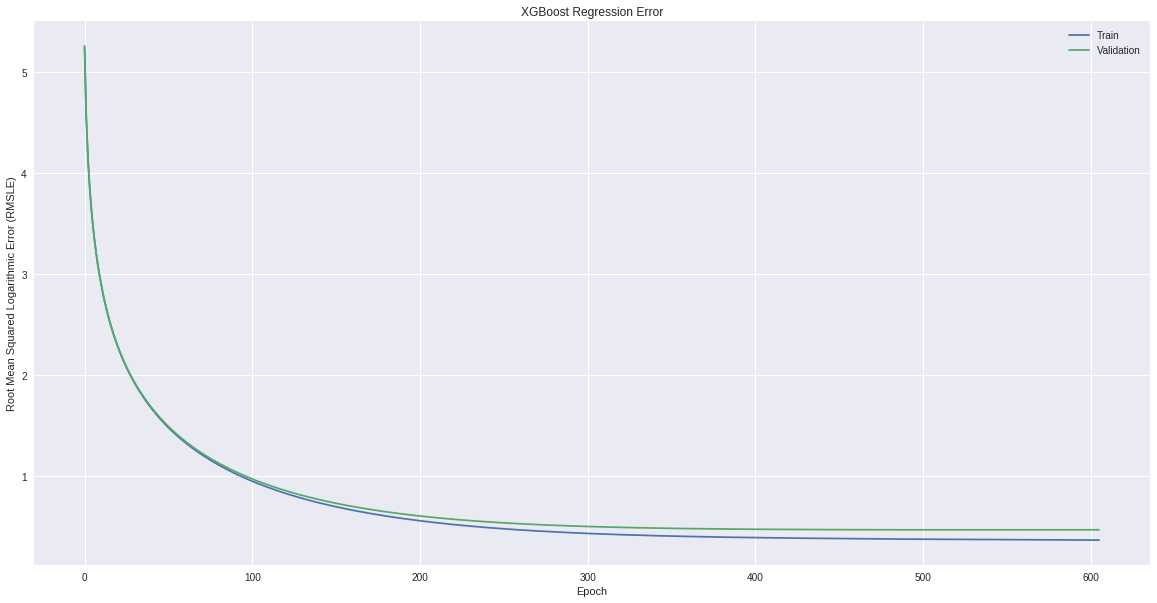

In [345]:
results = model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Validation')
ax.legend()
plt.ylabel('Root Mean Squared Logarithmic Error (RMSLE)')
plt.xlabel('Epoch')
plt.title('XGBoost Regression Error')
plt.show()

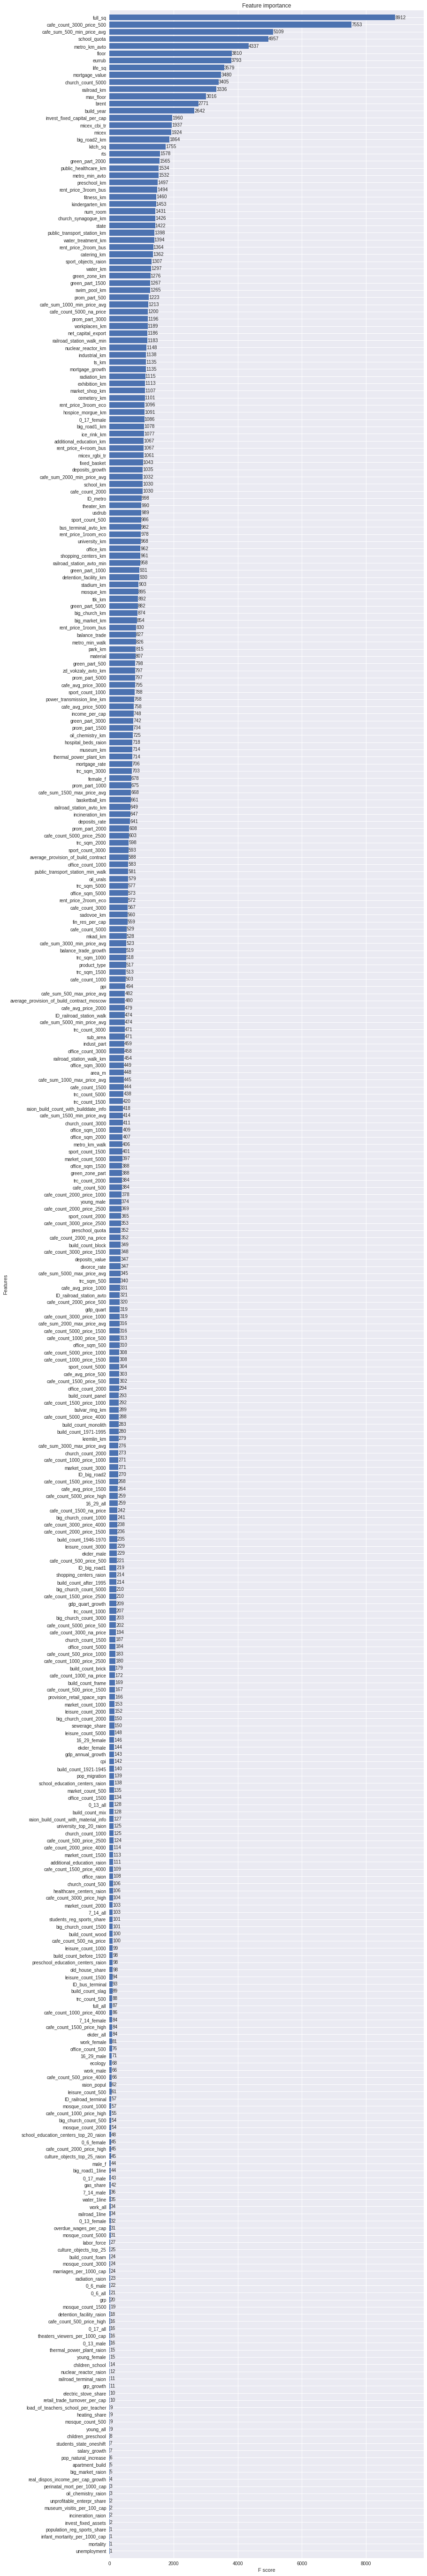

In [346]:
fig, ax = plt.subplots(figsize=(12,100))
xgb.plot_importance(model, height=0.8, ax=ax)

In [347]:
feature_importances_df = pd.DataFrame.from_dict(model.booster().get_score(), orient="index").reset_index()
feature_importances_df.columns = ['feature_name', 'importance_score']
feature_importances_df = feature_importances_df.sort_values(['importance_score'], ascending=[False])
feature_importances_df

,feature_name,importance_score
308,full_sq,8912
6,cafe_count_3000_price_500,7553
176,cafe_sum_500_min_price_avg,5109
36,school_quota,4957
9,metro_km_avto,4337
61,floor,3810
20,eurrub,3793
350,life_sq,3579
97,mortgage_value,3480
8,church_count_5000,3405


In [348]:
macro_importance_df = pd.merge(feature_importances_df, missing_df, left_on='feature_name', right_on='column_name', how='inner')
macro_importance_df

,feature_name,importance_score,column_name,missing_count,missing_count_perc
0,eurrub,3793,eurrub,3,0.120773
1,brent,2771,brent,3,0.120773
2,invest_fixed_capital_per_cap,1960,invest_fixed_capital_per_cap,293,11.795491
3,micex_cbi_tr,1937,micex_cbi_tr,1,0.040258
4,micex,1924,micex,10,0.402576
5,rts,1578,rts,10,0.402576
6,rent_price_3room_bus,1494,rent_price_3room_bus,273,10.990338
7,rent_price_2room_bus,1364,rent_price_2room_bus,273,10.990338
8,net_capital_export,1186,net_capital_export,396,15.942029
9,mortgage_growth,1135,mortgage_growth,365,14.694042


In [349]:
# Create test dataframe
test_columns = list(train_columns)
test_columns.append('id')

test_X =  test_macro_df[test_columns]
print("test_X.shape", test_X.shape)

test_X.shape (7662, 388)


In [350]:
# Predict
submission_columns = ['id', 'predicted_price_doc']
model = pickle.load(open(MODELS_PATH + model_id + ".xgb", 'rb'))
filename = SUBMISSIONS_PATH + 'submission-' + str(int(time.time())) + ".csv"
test_X = test_X.assign(predicted_price_doc_cpi=model.predict(test_X.loc[:, train_columns]))
test_X['predicted_price_doc'] = test_X['predicted_price_doc_cpi'] * test_X['cpi']
predicted_submission_df = test_X[submission_columns]
predicted_submission_df.columns = ['id', 'price_doc']
predicted_submission_df.to_csv(filename, index=False)
print('Generated submission file: {}'.format(filename))

Generated submission file: /kaggle/dev/sberbank-russian-housing-market-data/submissions/submission-1495549144.csv
